In [1]:
exec(open('init_notebook.py').read())

current working dirD:\ML\nlp\nlp-practice


In [29]:
import pandas as pd
import numpy as np
import numpy.typing as npt
import nltk
import seaborn as sns
import tqdm
import os
from nltk.corpus import stopwords
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import accuracy_score, balanced_accuracy_score

from nltk import word_tokenize
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import wget
import os

In [4]:
dataDir = os.path.join(projectFolder, "data")
dataDir

'D:/ML/nlp/nlp-practice\\data'

In [5]:
# url1 = "https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/edgar_allan_poe.txt"
# url2 = "https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/robert_frost.txt"
# wget.download(url1, out=dataDir)
# wget.download(url2, out=dataDir)

# Task = Given a Poem, who is the poet?
## Model using a Bayes-Classifier.

p(x|author1), p(x|author2) can be calculated by creating two markov models, one for author1 and one for author2. So, we can use unsupervised method for supervised task!

In [6]:
from classical.common_preprocess import *
from library.selection import *
import math

In [7]:
with open(os.path.join(dataDir, "edgar_allan_poe.txt")) as f:
    poeSentences = f.readlines()
with open(os.path.join(dataDir, "robert_frost.txt")) as f:
    frostSentences = f.readlines()

## Step 1: Lemmatize

In [8]:
poeSentences = lemmatize(poeSentences)
frostSentences = lemmatize(frostSentences)

## Step 2: train-test split

In [9]:
poTrain, poTest = split(poeSentences, 0.7)
frostTrain, frostTest = split(frostSentences, 0.7)

## Step 3: Build vocabulary based on the train sets

In [10]:
trainSet = poTrain + frostTrain

In [11]:
wordToIndex = buildWordToIndex (
    word_tokenize, 
    trainSet, 
    maxSize = 5000,
    # stopWords=stopwords.words('english'),
    stopWords=None,
    lowercase=True,
    ignorePunkt=True
)
idxToWord = {v: k for k, v in wordToIndex.items()}

*** top 10 words out of 1936 words***
the 594
be 304
and 301
of 277
i 275
a 270
to 239
in 200
it 188
that 147


In [12]:
vocabularySize = len(wordToIndex)
vocabularySize

1937

## Step 4: tokenize 

In [13]:
poTrainTokens = [tokenizeDoc(word_tokenize, doc, wordToIndex) for doc in poTrain]
frostTrainTokens = [tokenizeDoc(word_tokenize, doc, wordToIndex) for doc in frostTrain]

In [14]:
poTrainTokens[0]

[556, 418, 161, 557, 329, 5, 204]

In [15]:
poTrain[0]

"LO ! Death hath rear 'd himself a throne"

## Step 5: Build Markov Models

In [16]:
TransitionMatrix = npt.NDArray
MarginalProbabilities = npt.NDArray
Probablity = float

# Markov Model for an author
def buildMarkovModel(sentences: List[List[Token]], vocabularySize: int) -> Tuple[TransitionMatrix, MarginalProbabilities]:
    # step 1: initialize A, and pi
    
    pi = np.zeros(vocabularySize) + 0.000001 # no zeros
    A = np.zeros((vocabularySize, vocabularySize)) + 0.000001 # no zeros
    # print(vocabularySize)
    for aSenTokens in sentences:
        # print(aSenTokens)
        if len(aSenTokens) > 0:
            pi[aSenTokens[0]] += 1 # initial state
            for i in range(1, len(aSenTokens)): # i next, j is previous.
                iToken = aSenTokens[i]
                jToken = aSenTokens[i-1]
                A[iToken, jToken] += 1
                
    # now each column in A represents a previous word. So, we normalize the column to get probabilities P(i|j).
    
    A /= np.sum(A, axis=0)
    
    # followin is the validation check if each column adds up to 1
    # Asums = np.sum(A, axis=0)
    # ones = np.ones_like(Asums)
    # for col in range(len(Asums)):
    #     assert np.allclose(Asums, ones)
    
    return A, pi



In [17]:
poA, poPi = buildMarkovModel(poTrainTokens, vocabularySize)
frA, frPi = buildMarkovModel(frostTrainTokens, vocabularySize)

## Step 6: Bayes Model 

In [50]:


class Model:
    def __init__(self, tokenizer,  wordToIndex: Dict[WordRoot, Token], A1: TransitionMatrix, pi1: MarginalProbabilities, A2: TransitionMatrix, pi2: MarginalProbabilities):
        self.tokenizer = tokenizer
        self.wordToIndex = wordToIndex
        
        self.mdps = {
            1: [A1, pi1],
            2: [A2, pi2]
        }
        
    def getProbabiltyGivenLabel(self, lemmatizedSentence: Sentence, label: Label) -> Probablity:
        A, pi = self.mdps[label]
            
        aSenTokens = tokenizeDoc(self.tokenizer, lemmatizedSentence, self.wordToIndex)
        # assert len(aSenTokens) > 0
        if len(aSenTokens) == 0:
            return None
        # now we compute the joint probability of the sequence. What about the unknown and zeros?
        p = pi[aSenTokens[0]] * math.sqrt(len(aSenTokens)) # we scale by the size????
        for i in range(1, len(aSenTokens)):
            iToken = aSenTokens[i]
            jToken = aSenTokens[i-1]
            p *= A[iToken, jToken]
        return p # we don't need log probabilities as author probabilities are the same (assuming)
        
    def getLogProbabiltyGivenLabel(self, lemmatizedSentence: Sentence, label: Label) -> Probablity:
        A, pi = self.mdps[label]
            
        aSenTokens = tokenizeDoc(self.tokenizer, lemmatizedSentence, self.wordToIndex)
        # assert len(aSenTokens) > 0
        if len(aSenTokens) == 0:
            return None
        # now we compute the joint probability of the sequence. What about the unknown and zeros?
        p = np.log(pi[aSenTokens[0]])
        for i in range(1, len(aSenTokens)):
            iToken = aSenTokens[i]
            jToken = aSenTokens[i-1]
            p += np.log(A[iToken, jToken])
        return p # we don't need log probabilities as author probabilities are the same (assuming)
    
    def __call__(self, lemmatizedSentence: Sentence) -> Optional[Label]:
        
        pMax = -math.inf
        argMax = None
        for label in self.mdps:
            p = self.getLogProbabiltyGivenLabel(lemmatizedSentence, label)
            # print(p)
            if p is None:
                continue
            if p > pMax:
                pMax = p
                argMax = label
        return argMax
            
        
    

In [51]:
model = Model(
        tokenizer=word_tokenize,
        wordToIndex=wordToIndex,
        A1=poA,
        pi1=poPi,
        A2=frA,
        pi2=frPi
    )

In [52]:
poLabel = 1
frLabel = 2

In [53]:
model.getProbabiltyGivenLabel(poTest[2], 1)

1.784569290269994e-32

In [54]:
model(poTest[2])

1

# Step 7: Evaluate

In [55]:
# Train

0.6265734265734266 0.6292763157894736


C:\Users\adhocmaster\anaconda3\envs\nlptf\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


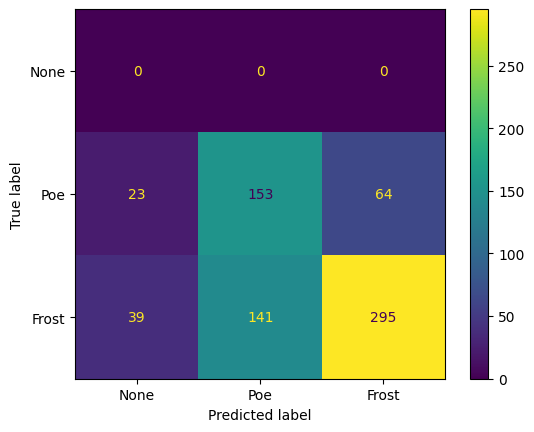

In [56]:
# build the confusion matrix
Y_pred = []
Y_test = []
for sen in poTest:
    pred = model(sen)
    if pred is None:
        pred = -1
    Y_pred.append(pred)
    Y_test.append(poLabel)
    
for sen in frostTest:
    pred = model(sen)
    if pred is None:
        pred = -1
    Y_pred.append(pred)
    Y_test.append(frLabel)
    
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["None", "Poe", "Frost"])
disp.plot()
print(accuracy_score(Y_test, Y_pred), balanced_accuracy_score(Y_test, Y_pred))

0.9001803968731209 0.9000019479191353


C:\Users\adhocmaster\anaconda3\envs\nlptf\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


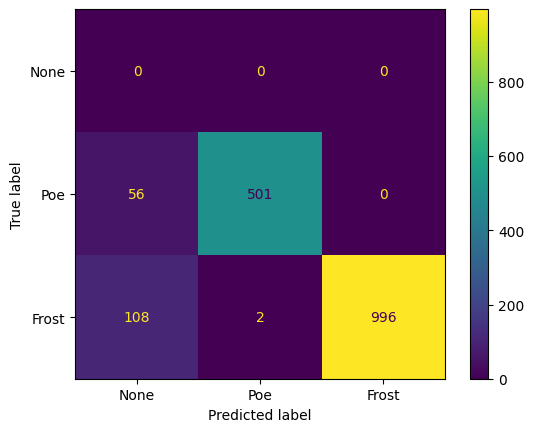

In [57]:
# build the confusion matrix
Y_pred = []
Y_test = []
for sen in poTrain:
    pred = model(sen)
    if pred is None:
        pred = -1
    Y_pred.append(pred)
    Y_test.append(poLabel)
    
for sen in frostTrain:
    pred = model(sen)
    if pred is None:
        pred = -1
    Y_pred.append(pred)
    Y_test.append(frLabel)
    
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["None", "Poe", "Frost"])
disp.plot()
print(accuracy_score(Y_test, Y_pred), balanced_accuracy_score(Y_test, Y_pred))
